# Lane Detection Algorithm
This Notebook contains the implementation of a simple lane detection algorithm. All functions defined below are also defined in separate files and combined in the main.py. This Notebook has been created for testing and first implementation.

In [51]:
%load_ext autoreload
%autoreload 2

# Import
import cv2 
import numpy as np 
import glob
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part 1: Camera calibration
The following cells include the implementation of a camera calibration function using openCV's functions and multiple views of a checkerboard.

In [52]:
def calibration():
    # Define the dimensions of the checkerboard
    CHECKERBOARD = (6, 9)

    # Stop the iteration when specified accuracy, epsilon, is reached or the specified number of iterations are completed.
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # Vector for 3D points
    points_3d = []

    # Vector for 2D points
    points_2d = []

    # 3D points real world coordinates
    object_p3d = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
    object_p3d[0, :, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
    prev_img_shape = None

    # Path containing images
    folder_path = 'camera_cal/'

    # Pattern for the image filenames
    image_pattern = folder_path + 'calibration*.jpg'

    # Use glob to get a list of filenames matching the pattern
    images = glob.glob(image_pattern)

    # Counter for the number of successfully processed images
    valid_image_count = 0

    for filename in images:
        image = cv2.imread(filename)

        if image is None:
            print(f"Unable to read image: {filename}")
            continue

        gray_color = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(
            gray_color,
            CHECKERBOARD,
            cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE
        )

        # If desired number of corners are found, refine the pixel coordinates and display them on the images of the checkerboard
        if ret:
            valid_image_count += 1
            points_3d.append(object_p3d)
            corners2 = cv2.cornerSubPix(gray_color, corners, (11, 11), (-1, -1), criteria)
            points_2d.append(corners2)

    # Check if there are enough valid images for calibration
    if valid_image_count < 3:
        print("Insufficient valid images for calibration. Calibration requires at least 3 images.")
    else:
        # Perform camera calibration
        ret, K, dist_coeff, _, _ = cv2.calibrateCamera(
            points_3d, points_2d, gray_color.shape[::-1], None, None
        )

        # Displaying estimated parameters
        print("Intrinsics matrix:")
        print(np.array2string(K, precision=4, suppress_small=True))

        print("\nDistortion coefficients:")
        print(np.array2string(dist_coeff, precision=4, suppress_small=True))


    return K, dist_coeff

K, dist_coeff = calibration()

Intrinsics matrix:
[[1156.9405    0.      665.9488]
 [   0.     1152.1388  388.7848]
 [   0.        0.        1.    ]]

Distortion coefficients:
[[-0.2376 -0.0854 -0.0008 -0.0001  0.1057]]


## Part 2: Homography transformation
To identify the lanes and compute their curvature a homography transformation must be applied to the points of the road in order to get a bird's eye view of the road. The following cells will deal with two main problems:

- **Get source points:** 
This part is needed to identify a region of interest of the road in front of the car. This region of interest is computed through Canny edge detection and Hough transform on a test image with straight lanes. In order to account for turns and curved lanes, the region of interest is bigger than the one contained within the lanes themselves.

- **Compute homography transformation:** 
Using openCV's getPerspectiveTransform() and the source points previously derived, the homography transformation and its inverse are computed.


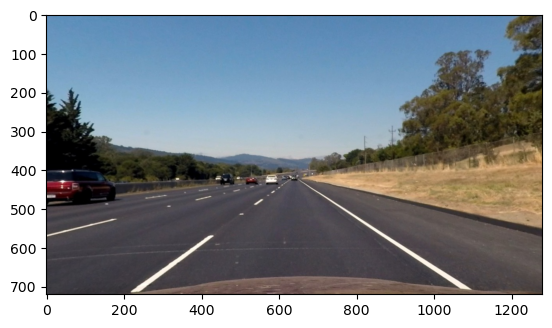

In [3]:
# Undistort image
image = cv2.imread('test_images/test7.jpg')
undistorted_image = cv2.undistort(image, K, dist_coeff)
undistorted_image = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB)

# Plot image to get coordinates
plt.imshow(undistorted_image)
plt.show()

The continuous black line on the right is identified through Canny edge detection and Hough transform. The slope is then inverted to define the vertices of the quadrangle needed for computing the Homography transformation.

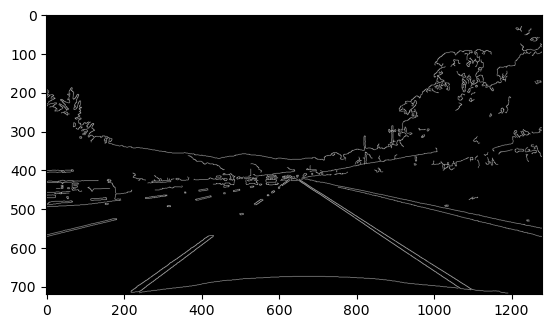

In [4]:
## Apply Canny edge detection algorithm
gray_image = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2GRAY)
# Apply Gaussian blur to reduce noise (optional, but recommended)
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
edges = cv2.Canny(blurred_image, 50, 150)

plt.imshow(edges, cmap='gray')
plt.show()

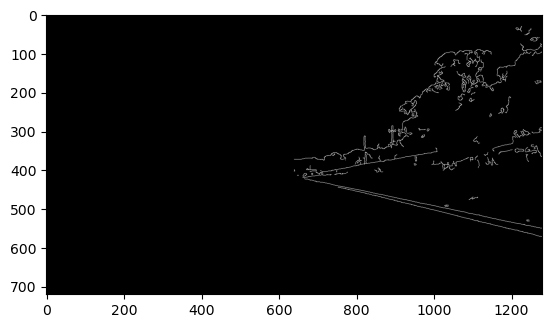

In [33]:
## Mask right side of the picture
# Define polygon of interest
H, W = gray_image.shape
poly = np.array([
    [(int(W/2), 0), (W, 0), (W, H), (int(W/2), int(H/2) + 50)]
])
# Create black mask with white polygon
mask = np.zeros_like(edges)
cv2.fillPoly(mask, poly, 255)
# Apply masking
masked_image = cv2.bitwise_and(edges, mask)

plt.imshow(masked_image, cmap='gray')
plt.show()

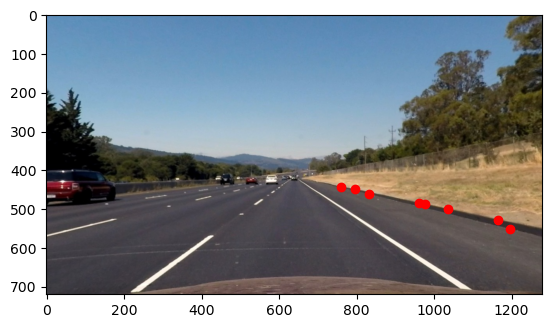

In [34]:
## Use Hough transform to find lines
lines = cv2.HoughLinesP(masked_image, 2, np.pi / 180, 100, np.array([]), minLineLength=100, maxLineGap=5)
lines = np.squeeze(lines)
x = np.concatenate([lines[:,0], lines[:,2]])
y = np.concatenate([lines[:,1], lines[:,3]])

plt.imshow(undistorted_image)
plt.scatter(x, y, c='red', marker='o')
plt.show()

[795, 1863] [450, 685]


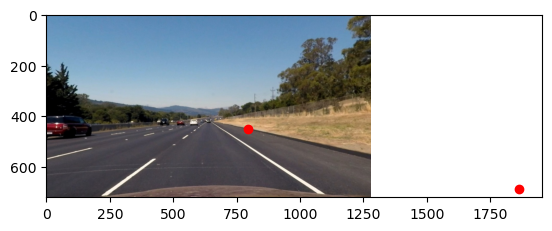

In [35]:
## Average lines to get a unique line
slopes = []
intercepts = []
for line in lines:
    x1, y1, x2, y2 = line
    # Offset points in x direction not to include the edges
    slope, intercept = np.polyfit((x1, x2), (y1, y2), 1)
    slopes.append(slope)
    intercepts.append(intercept)

slope_right = np.average(np.array(slopes), axis=0)
intercept_right = np.average(np.array(intercepts), axis=0)

# Define points
y1 = 450
x1 = int((y1 - intercept_right)/slope_right)
y2 = 685
x2 = int((y2 - intercept_right) / slope_right)

right_x = [x1, x2]
right_y = [y1, y2]
print([x1, x2], [y1, y2])

plt.imshow(undistorted_image)
plt.scatter(right_x, right_y, c='red', marker='o')
plt.show()

[484, -583] [450, 685]


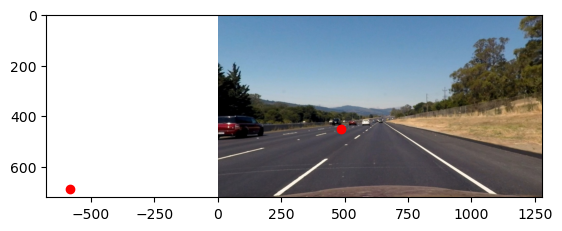

In [36]:
slopes = []
intercepts = []
for line in lines:
    x1, y1, x2, y2 = line
    x1 = int(W - x1)
    x2 = int(W - x2)
    # Offset points in x direction not to include the edges
    slope, intercept = np.polyfit((x1, x2), (y1, y2), 1)
    slopes.append(slope)
    intercepts.append(intercept)

slope_left = np.average(np.array(slopes), axis=0)
intercept_left = np.average(np.array(intercepts), axis=0)

# Define points
y1 = 450
x1 = int((y1 - intercept_left)/slope_left)
y2 = 685
x2 = int((y2 - intercept_left) / slope_left)

left_x = [x1, x2]
left_y = [y1, y2]
print([x1, x2], [y1, y2])

plt.imshow(undistorted_image)
plt.scatter(left_x, left_y, c='red', marker='o')
plt.show()

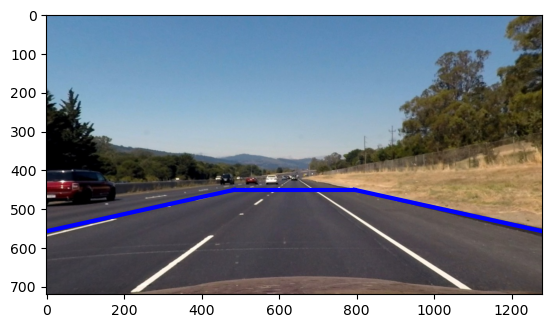

In [37]:
## Display region of interest (only points within the limits of the image are displayed)
top_left = [left_x[0], left_y[0]]
top_right = [right_x[0], right_y[0]]
bottom_left = [0, intercept_left]
bottom_right = [W-1, intercept_left] # W-1 is used otherwise the point would lie outside the image

plt.imshow(undistorted_image)
plt.plot([top_left[0], top_right[0]], [top_left[1], top_right[1]], color='blue', linewidth=3)
plt.plot([top_right[0], bottom_right[0]], [top_right[1], bottom_right[1]], color='blue', linewidth=3)
plt.plot([bottom_left[0], top_left[0]], [bottom_left[1], top_left[1]], color='blue', linewidth=3)
plt.show()

(668, 417)


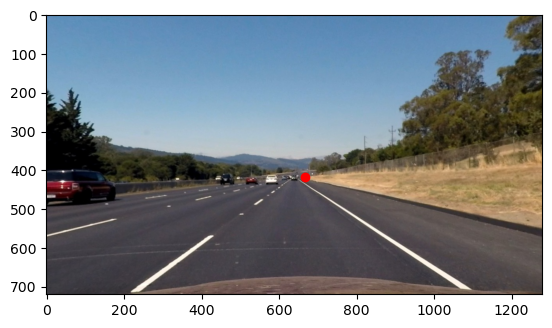

In [48]:
## Compute point of intersection of all lines
# Canny
gray_image = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2GRAY)
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
edges = cv2.Canny(blurred_image, 50, 150)
# Region of interest
H, W = gray_image.shape
poly = np.array([
    [(int(W/2), 0), (W, 0), (W, H), (int(W/2), H)]
])
mask = np.zeros_like(edges)
cv2.fillPoly(mask, poly, 255)
masked_image = cv2.bitwise_and(edges, mask)
# Hough transform
lines = cv2.HoughLinesP(edges, 2, np.pi / 180, 100, np.array([]), minLineLength=130, maxLineGap=3)
lines = np.squeeze(lines)

# Compute point of intersection between the left and right lines
total_x_int = 0
total_y_int = 0
count = 0

for i in range(len(lines)-1):
    for j in range(i+1, len(lines)):
        x1, y1, x2, y2 = lines[i]
        x3, y3, x4, y4 = lines[j]

        # Check if lines are not parallel
        determinant = (x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4)
        if determinant != 0:
            x_int = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4)) / determinant
            y_int = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4)) / determinant

            total_x_int += x_int
            total_y_int += y_int
            count += 1

if count != 0:
    x_int = total_x_int / count
    average_y_int = total_y_int / count

print((int(x_int), int(y_int)))

plt.imshow(undistorted_image)
plt.scatter(int(x_int), int(y_int), c='red', marker='o')
plt.show()

In [49]:
# The intersection point is needed to compute new lines that are slightly offset from the the lines found above
offset = 60
y_max = 685
y_min = 450

# Left line
slope_left = (y_int - y_min)/(x_int - (left_x[0] + offset))
top_left = (left_x[0] + offset, y_min)
bottom_left = (int(x_int + (y_max - y_int)/slope_left), y_max)

# Right line
slope_right = (y_int - y_min)/(x_int - (right_x[0] - offset))
top_right = (right_x[0] - offset, y_min)
bottom_right = (int(x_int + (y_max - y_int)/slope_right), y_max)

max_width = max(len(str(coord)) for point in [top_left, bottom_left, top_right, bottom_right] for coord in point)

# Format and print the points with aligned numbers
print(f'Top left:      {top_left[0]:>{max_width}}, {top_left[1]:>{max_width}}')
print(f'Bottom left:   {bottom_left[0]:>{max_width}}, {bottom_left[1]:>{max_width}}')
print(f'Top right:     {top_right[0]:>{max_width}}, {top_right[1]:>{max_width}}')
print(f'Bottom right:  {bottom_right[0]:>{max_width}}, {bottom_right[1]:>{max_width}}')

Top left:       544,  450
Bottom left:   -349,  685
Top right:      735,  450
Bottom right:  1211,  685


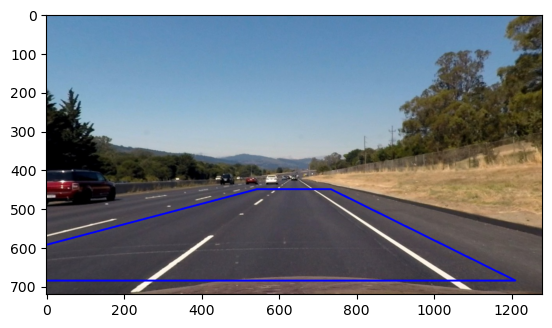

In [50]:
# Create a copy of the image to avoid modifying the original
image_with_roi = np.copy(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))

# Convert points to integer
top_left = tuple(map(int, top_left))
top_right = tuple(map(int, top_right))
bottom_left = tuple(map(int, bottom_left))
bottom_right = tuple(map(int, bottom_right))

# Draw the polygon on the image
cv2.polylines(image_with_roi, [np.array([top_left, top_right, bottom_right, bottom_left])], isClosed=True, color=(255, 0, 0), thickness=3)


# Save the image in the 'output' folder
cv2.imwrite('outputs/roi_image.png', image_with_roi)

# Display the image with the polygon
cv2.imshow('ROI Image', image_with_roi)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.imshow(cv2.cvtColor(image_with_roi, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# The points derived earlier are used as source points for the homography transformation
src_points = np.float32([
    bottom_left,    # bottom-left corner
    top_left,       # top-left corner
    top_right,      # top-right corner
    bottom_right    # bottom-right corner
])

# Destination points are to be parallel, taking into account the image size
dst_points = np.float32([
    [0, 600],           # bottom-left corner
    [0, 0],             # top-left corner
    [500, 0],           # top-right corner
    [500, 600]          # bottom-right corner
])

# Calculate the transformation matrix and it's inverse transformation
M = cv2.getPerspectiveTransform(src_points, dst_points)
M_inv = cv2.getPerspectiveTransform(dst_points, src_points)
warped = cv2.warpPerspective(undistorted_image, M, (600, 500))
    
    
cv2.imshow('img', warped)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.imshow(warped)
plt.show()

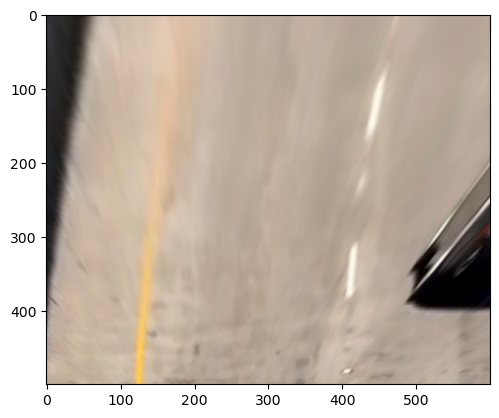

In [59]:
# Function definition
def get_top_view(image):
    # The points derived earlier are used as source points for the homography transformation
    src_points = np.float32([
        [-79,  685],       # bottom-left corner
        [550,  450],         # top-left corner
        [729,  450],        # top-right corner
        [1406,  685]        # bottom-right corner
    ])
    
    # Destination points are to be parallel, taking into account the image size
    dst_points = np.float32([
        [0, 600],           # bottom-left corner
        [0, 0],             # top-left corner
        [500, 0],           # top-right corner
        [500, 600]          # bottom-right corner
    ])
    
    # Calculate the transformation matrix and it's inverse transformation
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    M_inv = cv2.getPerspectiveTransform(dst_points, src_points)
    warped = cv2.warpPerspective(image, M, (600, 500))
    
    return M, M_inv, warped

# Test on different image
image = cv2.imread('test_images/test1.jpg')
undistorted_image = cv2.undistort(image, K, dist_coeff)


M, M_inv, warped = get_top_view(undistorted_image)
     
# cv2.imshow('img', warped)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

## Part 3: Thresholding
In order to identify the lanes in the image a series of thresholding is applied to robustly identify lanes in various conditions. A combination of colour and gradient thresholding is applied. 

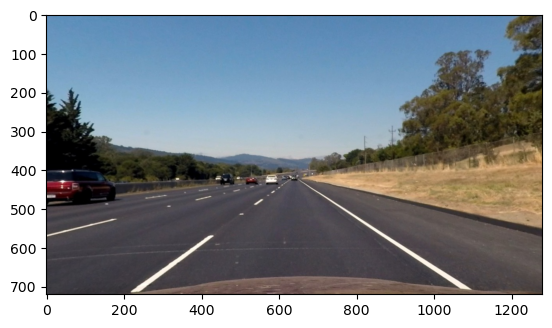

In [54]:
image = cv2.imread('test_images/test7.jpg')
undistorted_image = cv2.undistort(image, K, dist_coeff)

plt.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))
plt.show()

### 1) Sobel x thresholding
The first filtering is done by applying a Sobel kernel to the L channel of the image to compute the derivative of the image in the x direction. The reason behind this threshold is that lanes tend to be vertical, which means that they can be easily identified by looking for changes in intensity along the horizontal direction. Furthermore, the lightness channel of the HLS representation is used to identify abrupt changes in brightness. 

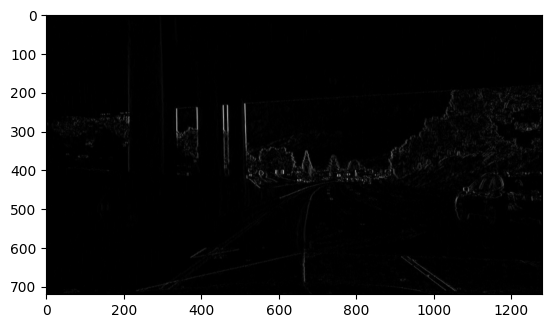

In [126]:
# Convert image to HLS color space
hls = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2HLS)
l_channel = hls[:,:,1]

# Compute derivative in the x direction of L channel
abs_sobelx = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0))
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
sobelx_thresh=(20, 255)
sobelx_binary = np.zeros_like(scaled_sobel)
sobelx_binary[(scaled_sobel >= sobelx_thresh[0]) & (scaled_sobel <= sobelx_thresh[1])] = 1

plt.imshow(scaled_sobel, cmap='gray')
plt.show()

### 2) Colour thresholding
After the gradient treshold, a threshold is applied to the gray representation of the image, in order to identify white pixels, and to the L and S channels of the HLS representation, to once again identify only the lanes.

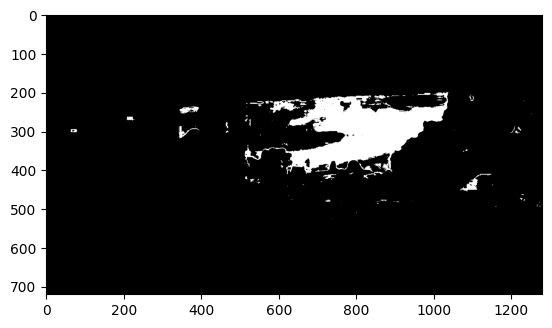

In [142]:
# Convert image to HLS color space
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
h_channel = hls[:,:,0]

# Threshold S color channel for white and yellow lanes
s_thresh=(50, 255)
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

# Threshold H color channel for yellow lanes
h_thresh=(10, 25)  # Approximate range for yellow hues
h_binary = np.zeros_like(h_channel)
h_binary[(h_channel > h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

# Combine binary images
hs_binary = np.zeros_like(s_channel)
hs_binary[(s_binary == 1) | (h_binary == 1)] = 1

w_thresh=(165, 255)
gray_image = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2GRAY)
white_binary = np.zeros_like(gray_image)
white_binary[(gray_image > w_thresh[0]) & (gray_image < w_thresh[1])] = 1

color_binary = cv2.bitwise_or(hs_binary, white_binary)
plt.imshow(hs_binary, cmap='gray')
plt.show()

In [ ]:
# Convert the image to LAB color space
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# Extract the B channel (yellow-blue channel)
b_channel = lab_image[:, :, 2]

# Threshold B channel for yellow lanes
b_binary = np.zeros_like(b_channel)
b_binary[(b_channel >= 150) & (b_channel <= b_thresh[1])] = 1

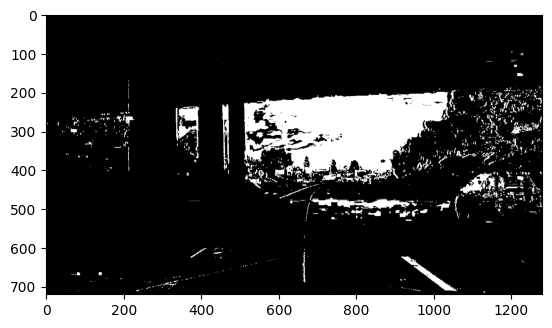

In [132]:
combined_binary = cv2.bitwise_or(color_binary, sobelx_binary)
plt.imshow(combined_binary, cmap='gray')
plt.show()

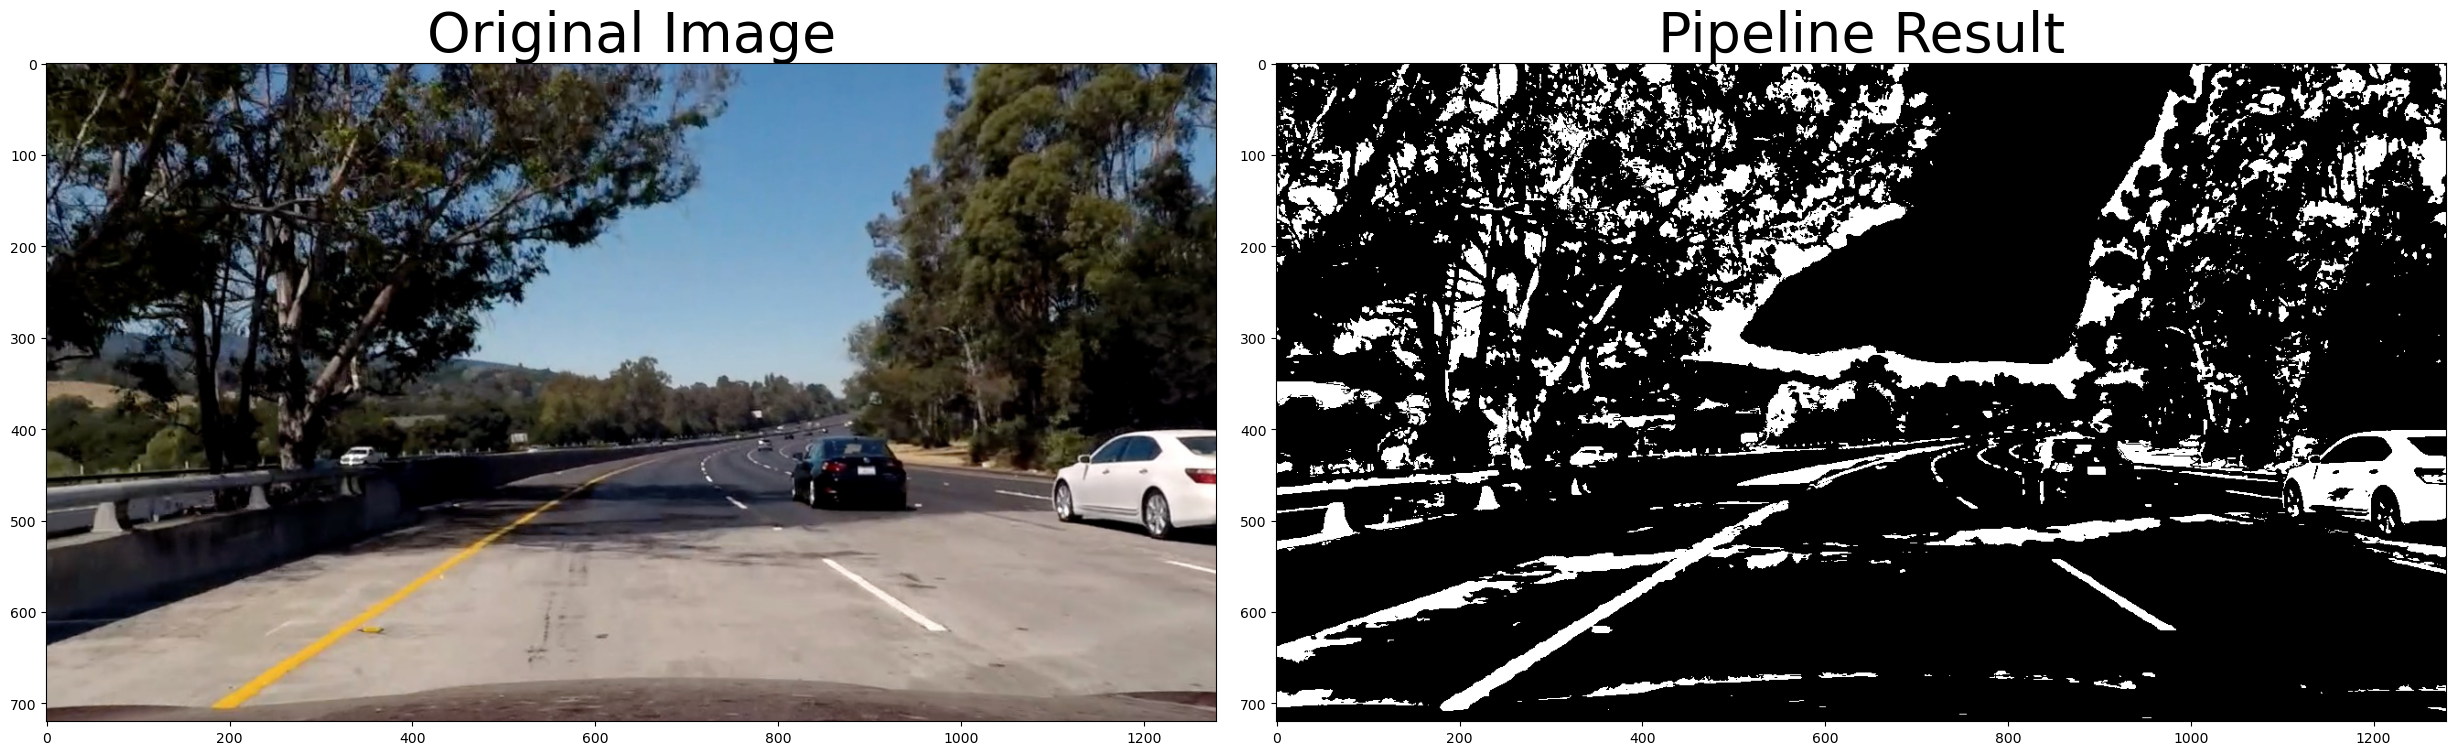

In [64]:
# The following function implements the thresholds shown previously in a single function to be used in the final pipeline

def color_and_gradient_tresh(image, w_thresh=(165, 255), h_thresh=(10, 25), s_thresh=(50, 255), sobelx_thresh=(20, 100)):
    
    # Convert image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Convert image to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    # Convert image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Yellow detection
    adapt_yellow_S = cv2.adaptiveThreshold(hls[:, :, 2], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow_B = cv2.adaptiveThreshold(lab[:, :, 2], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow = adapt_yellow_S & adapt_yellow_B

    # White detection
    adapt_white_R = cv2.adaptiveThreshold(image[:, :, 0], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white_L = cv2.adaptiveThreshold(hsv[:, :, 2], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white = adapt_white_R & adapt_white_L

    # Combine yellow and white detections
    combined_binary = adapt_yellow | adapt_white

    return combined_binary

image = cv2.imread('test_images/test5.jpg')
undistorted_image = cv2.undistort(image, K, dist_coeff)
result = color_and_gradient_tresh(undistorted_image)


# Plot the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Part 4: Lane identification
In this part we take the results of the previous parts, mainly the computed warped image and the thresholding, to identify lanes in the image. On top of this, we also compute the curvature of the lanes.

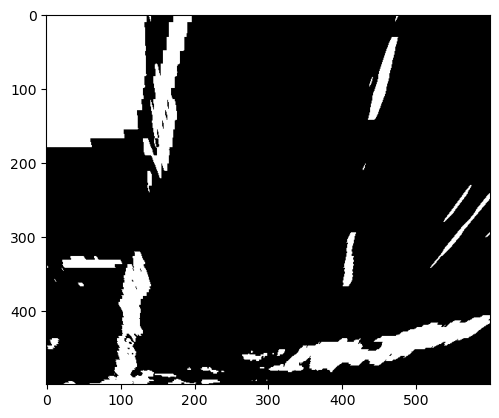

In [63]:
image = cv2.imread('test_images/test5.jpg')
undistorted_image = cv2.undistort(image, K, dist_coeff)

def filter_top_view(image):
    thresholded_image = color_and_gradient_tresh(image)
    _, Minv, binary_warped = get_top_view(thresholded_image)

    return binary_warped, Minv

binary_warped, Minv = filter_top_view(undistorted_image)

plt.imshow(binary_warped, cmap='gray')
plt.show()

To find lanes in the top-down view of the thresholded image we will use a histogram search: we take a a fixed number of rows, compute the sum along the columns and identify the peaks in the histogram, which correspond to the position of the lanes. We then repeat this process by sliding a window across the whole image.

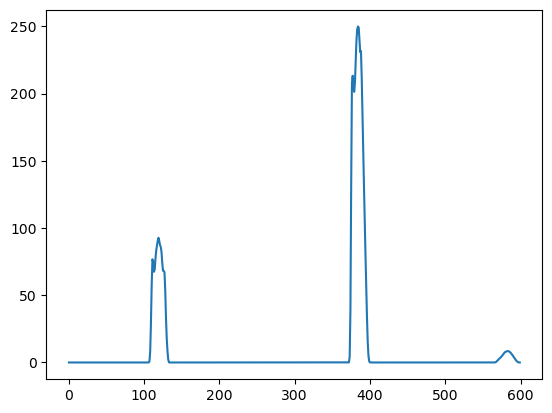

In [20]:
binary_warped = binary_warped / 255
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):, :], axis=0)
plt.plot(histogram)
plt.show()

In this snipped of code, we have taken the bottom half of the image and computed an histogram along the vertical direction, by summing the values. The highest peak correspond to the vertical lane on the right, while the second peak on the left corresponds to the lane on the left, which however is discontinued, hence the lower value. To select them we could divide by half the search space and identify the highest peak in the left and right part, in order to be able to correctly identify the two lanes. 

To generalize the method and use it also on curved lanes, a different image must be used and more importantly a sliding window histogram must be implemented.


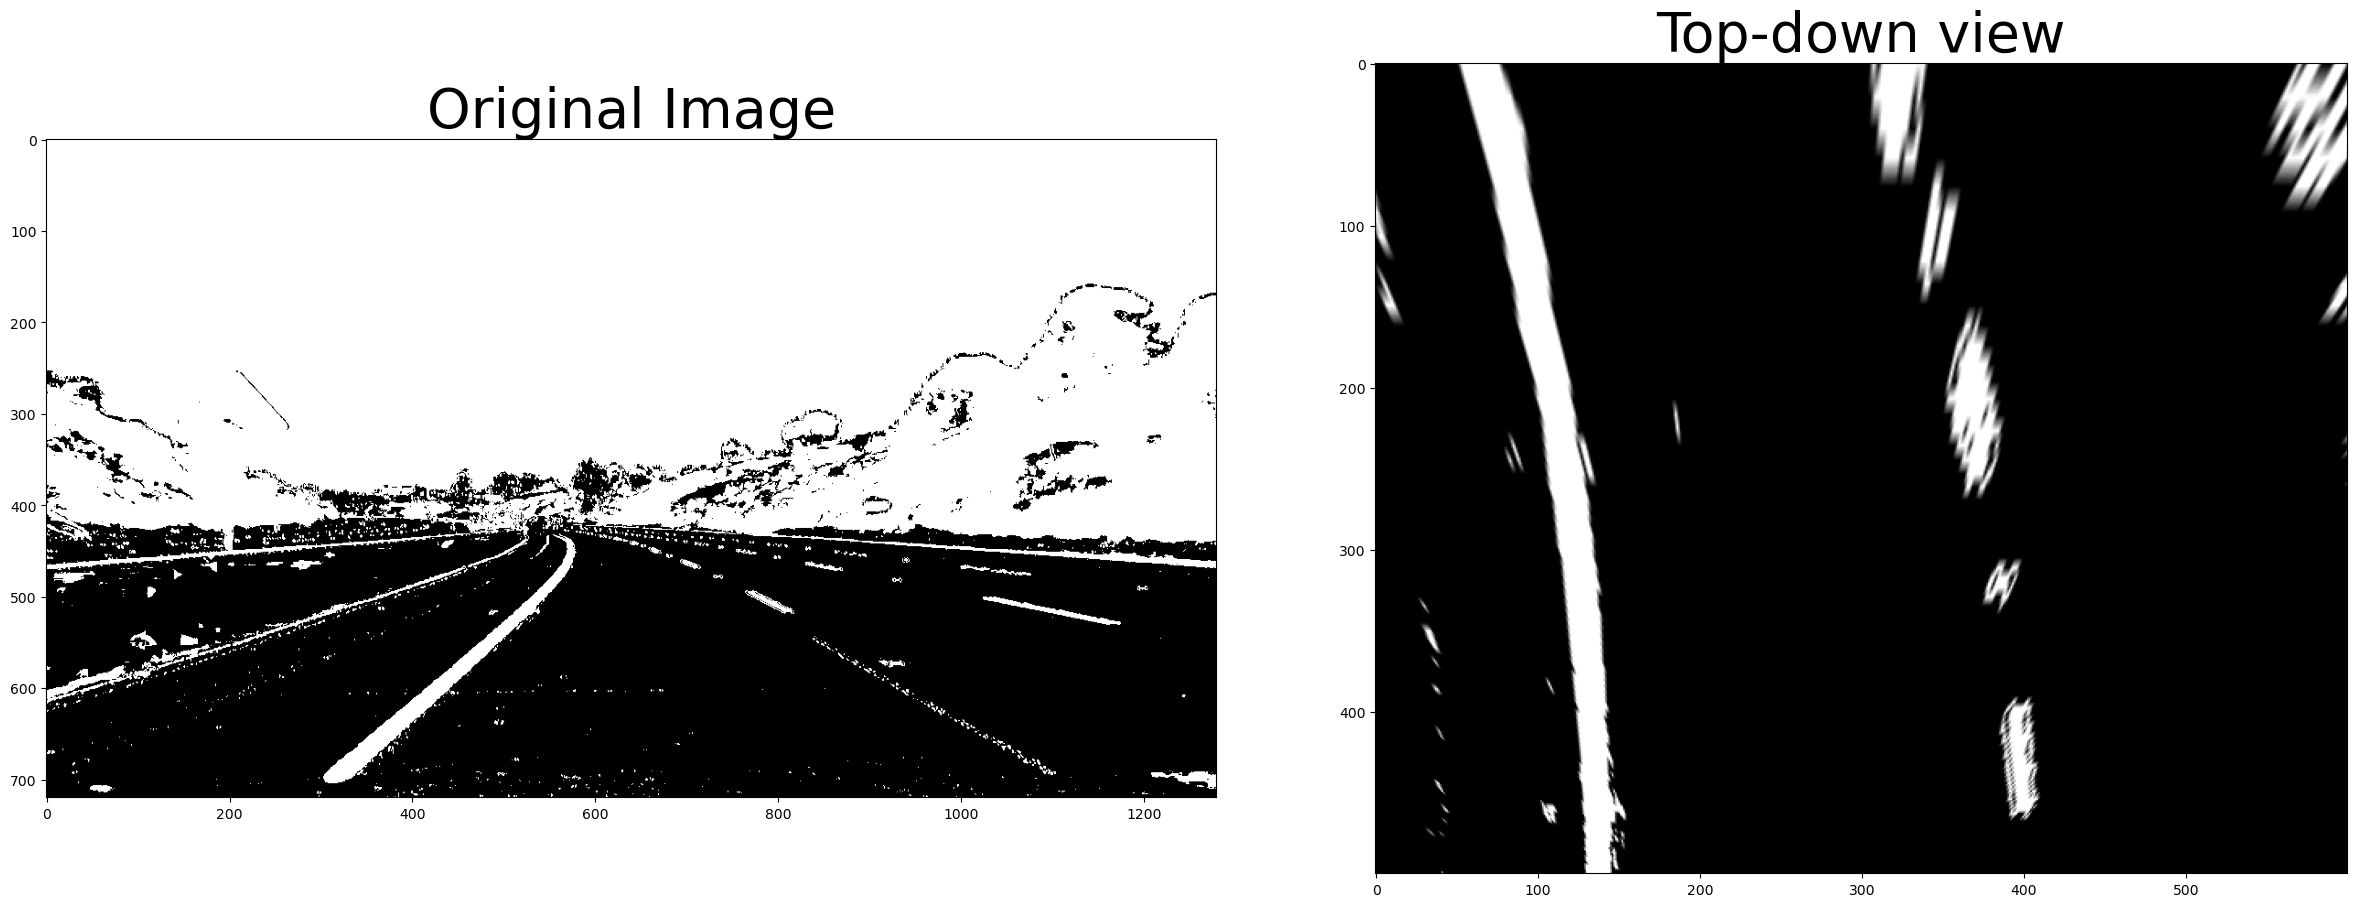

In [26]:
image = cv2.imread('test_images/test2.jpg')
undistorted_image = cv2.undistort(image, K, dist_coeff)

binary_warped = filter_top_view(undistorted_image)


# Plot the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

thresholded_image, _ = color_and_gradient_tresh(undistorted_image)
ax1.imshow(thresholded_image, cmap='gray')
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Top-down view', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

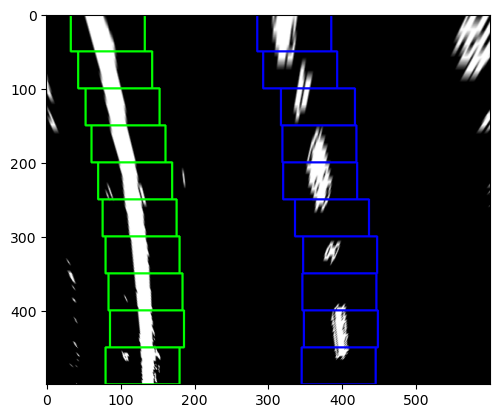

In [27]:
def histogram(binary_warped):
    
    # Take a histogram of the bottom half of the image to detect initial position of lanes
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Output image to visualize results later
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    midpoint = int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    # Note that x and y are swapped because y corresponds to the row index and x to the column index
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        # Four boundaries of left and right windows
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,0,255), 2) 
        
        #Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

binary_warped = filter_top_view(undistorted_image)
leftx, lefty, rightx, righty, out_img = histogram(binary_warped)
plt.imshow(out_img)
plt.show()

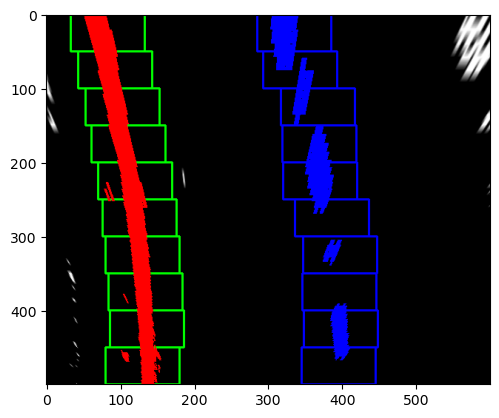

In [41]:
def fit_polynomial(binary_warped):
    # Find lane pixels using sliding window histogram search
    leftx, lefty, rightx, righty, out_img = histogram(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    # plt.plot(left_fitx, ploty, color='yellow')
    # plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, ploty

out_img, left_fit, right_fit, ploty = fit_polynomial(binary_warped)

plt.imshow(out_img)
plt.show()

Applying this algorithm to process each image works, but we can improve it by exploiting at each time step useful information from the previous frame. As a matter of fact, from one frame to the other, the lanes don't change much, which means that we can use the polynomial fitted on the previous frame to identify a search area for the pixels in the current frame. This allows to save much time, since we already know approximately where to look.

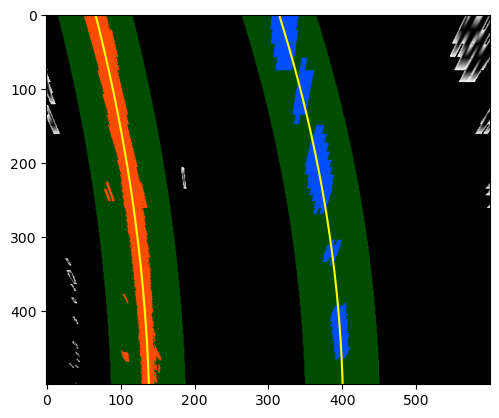

In [39]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Computes both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Area of search based on fit of previous frame
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result


result = search_around_poly(binary_warped, left_fit, right_fit)

plt.imshow(result)
plt.show()

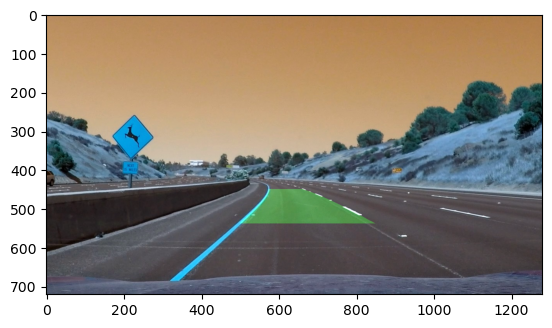

In [64]:
image = cv2.imread('test_images/test2.jpg')
undistorted_image = cv2.undistort(image, K, dist_coeff)

binary_warped, Minv = filter_top_view(undistorted_image)
out_img, left_fit, right_fit, ploty = fit_polynomial(binary_warped)

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
# Create an image to draw the lines on
color_area = np.zeros((500, 600, 3), dtype=np.uint8)

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.column_stack((left_fitx, ploty))
pts_right = np.column_stack((right_fitx, ploty))

# Concatenate points
pts = np.concatenate((pts_left, pts_right[::-1]), axis=0)

# Draw the lane onto the warped blank image
cv2.fillPoly(color_area, [pts.astype(np.int32)], (0, 255, 0))

warped_color = cv2.warpPerspective(color_area, M_inv, (image.shape[1], image.shape[0]))

result = cv2.addWeighted(image, 1, warped_color, 0.3, 0)

plt.imshow(result)
plt.show()

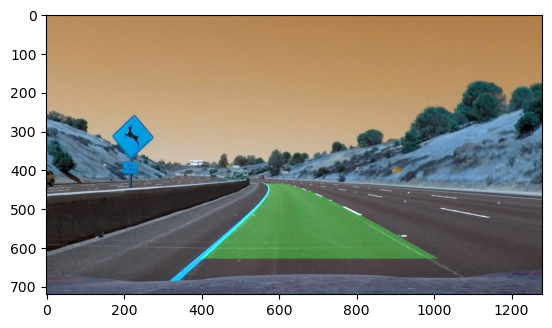

In [86]:
binary_warped, Minv = filter_top_view(undistorted_image)
out_img, left_fit, right_fit, ploty = fit_polynomial(binary_warped)

ploty = np.concatenate((np.arange(-500, 0), ploty, np.arange(ploty[-1], ploty[-1] + 80)))
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw the lines on
height, width, _ = image.shape
color_warp = np.zeros((height, width, 3), dtype=np.uint8)

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.column_stack((left_fitx, ploty, np.ones(len(left_fitx))))
pts_right = np.column_stack((right_fitx, ploty, np.ones(len(left_fitx))))

# Multiply points by Minv to transform them back in the image
pts_left_warped = np.dot(Minv, pts_left.T).T
pts_left_warped = np.divide(pts_left_warped[:, :2], pts_left_warped[:, 2].reshape(-1, 1))

pts_right_warped = np.dot(Minv, pts_right.T).T
pts_right_warped = np.divide(pts_right_warped[:, :2], pts_right_warped[:, 2].reshape(-1, 1))

# Reshape points for fillPoly
pts_left_warped = pts_left_warped.reshape((-1, 1, 2))
pts_right_warped = pts_right_warped.reshape((-1, 1, 2))

# Concatenate points
pts = np.concatenate((pts_left_warped, pts_right_warped[::-1]), axis=0)

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, [pts.astype(np.int32)], (0, 255, 0))

# Combine the result with the original image
result = cv2.addWeighted(image, 1, color_warp, 0.3, 0)

plt.imshow(result)
plt.show()

In [179]:
def generate_data():
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    
    return ploty, left_fit, right_fit

    
def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Computation of radius of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)

1564.0916261695256 1791.327347563986


1862.348559803444 1547.618759905877


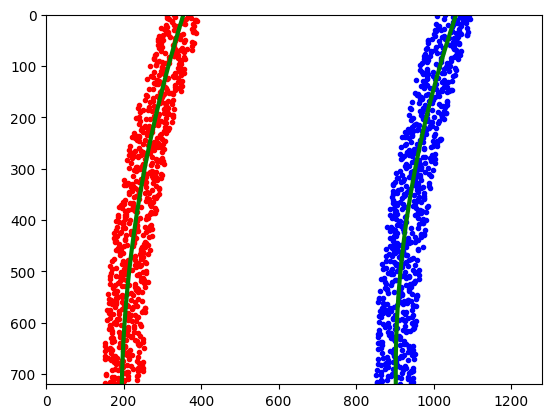

In [183]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Computation of radius of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit)
print(left_curverad, right_curverad)


# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

## Test on video

In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

from main import LaneDetection
%load_ext autoreload
%autoreload 2

Loaded Intrinsics matrix:
[ 1156.94 0.00 665.95 ]
[ 0.00 1152.14 388.79 ]
[ 0.00 0.00 1.00 ]

Loaded Distortion coefficients:
-0.238 -0.085 -0.001 -0.000 0.106 

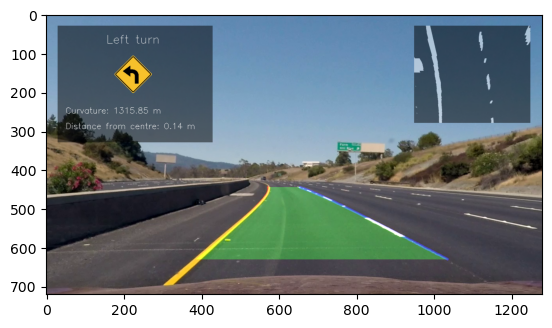

In [103]:
cap = cv2.VideoCapture('test_videos/project_video.mp4')
cap.set(cv2.CAP_PROP_POS_MSEC, 0 * 1000)

ld = LaneDetection()

# Read the first frame
ret, frame_1 = cap.read()

result = ld.process_new_frame(frame_1)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

cv2.imshow('result', result)
cv2.waitKey(0)
cv2.destroyAllWindows()

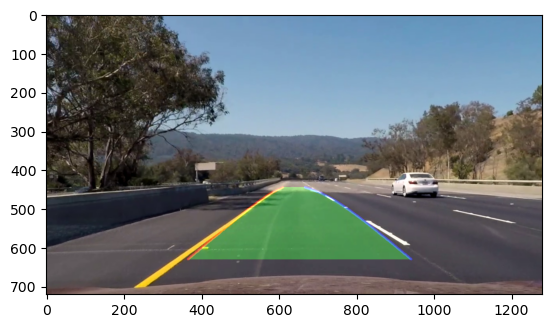

In [54]:
ret, frame_2 = cap.read()
result = ld.process_new_frame(frame_2)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

In [119]:
ld = LaneDetection()
cap = cv2.VideoCapture('test_videos/project_video.mp4')
frame_rate = cap.get(cv2.CAP_PROP_FPS)  # Get the frame rate of the video
start_time = 0 # Start time in seconds
end_time = 30  # End time in seconds
total_frames = int(frame_rate * (end_time - start_time))  # Total frames to display for the given duration

# Seek to the start time
cap.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)
frame_count = 0

# Represent thresholded frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame_count >= total_frames or cv2.waitKey(3) == ord('q'):
        break

    result = ld.process_new_frame(frame)
    
    thresholded_image = ld.color_and_gradient_tresh(frame)
    _, _, thresh_warped = ld.get_top_view(thresholded_image)
    cv2.imshow('Detected lanes', result)
    frame_count += 1
    
cap.release()
cv2.destroyAllWindows()

Loaded Intrinsics matrix:
[ 1156.94 0.00 665.95 ]
[ 0.00 1152.14 388.79 ]
[ 0.00 0.00 1.00 ]

Loaded Distortion coefficients:
-0.238 -0.085 -0.001 -0.000 0.106 Loaded Intrinsics matrix:
[ 1156.94 0.00 665.95 ]
[ 0.00 1152.14 388.79 ]
[ 0.00 0.00 1.00 ]

Loaded Distortion coefficients:
-0.238 -0.085 -0.001 -0.000 0.106 